In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif
from desc.utils import flatten_list

#from ..utils import cross, dot, safediv, safenorm
#from desc.compute.utils import cross
#from desc.compute.utils import dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, 
                                  ToroidalMagneticField,
                                  field_line_integrate)

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray


from desc.derivatives import Derivative

# Import my own functions
from desc.fns_simp import (#data_eval, 
                           #_compute_magnetic_field_from_Current,
                           plot_figure,
                           plot_figure2,
                           #plot_xy,
                           #surf_int
                          )

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory

In [3]:
#from desc.continuation import solve_continuation_automatic

from desc.objectives import (
    #AspectRatio,
    #FixBoundaryR,
    #FixBoundaryZ,
    #FixCurrent,
    #FixPressure,
    #FixPsi,
    #ForceBalance,
    ObjectiveFunction,
    #QuasisymmetryTwoTerm,
    #RotationalTransform,
    FixParameters, 
    ShareParameters,
    QuadraticFlux, 
    SurfaceCurrentRegularization, 
    bRegularization_fd,
    CoilThicknessRegularization,
    PlasmaVesselDistance,
    MeanCurvature,
    PrincipalCurvature,
)
from desc.optimize import Optimizer

In [4]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

In [5]:
eq = eq_QA

R0 = 1.0
a = 0.3

surf = FourierRZToroidalSurface(R_lmn=[R0,a], 
                                Z_lmn=[-a],
                                modes_R=np.array([[0,0],[1,0]]),
                                modes_Z=np.array([[-1,0]]),
                                NFP=eq.NFP
                               )
surf.change_resolution(N=eq.N)

eq.axis.R_n = eq_QA.axis.R_n + 0.5*(eq_QH.axis.R_n - eq_QA.axis.R_n)
eq.axis.Z_n = eq_QA.axis.Z_n + 0.5*(eq_QH.axis.Z_n - eq_QA.axis.Z_n)

######
for coef, mode in zip(eq.axis.R_n, eq.axis.R_basis.modes):
    n = mode[-1]
    surf.R_lmn=surf.R_lmn.at[surf.R_basis.get_idx(M=0,N=n)].set( coef)
for coef, mode in zip(eq.axis.Z_n, eq.axis.Z_basis.modes):
    n = mode[-1]
    surf.Z_lmn=surf.Z_lmn.at[surf.Z_basis.get_idx(M=0,N=n)].set( coef)

In [6]:
surf1 = surf

# Generate a Surface Current field for RQH
surf2 = surf1.copy()
#surf2.G = G_QH

surf2.change_resolution(M = 12,N = 10)
#surf2.change_Phi_resolution(M = 12,N = 12)
#surf2.M_Phi = 13
#surf2.N_Phi = 13

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

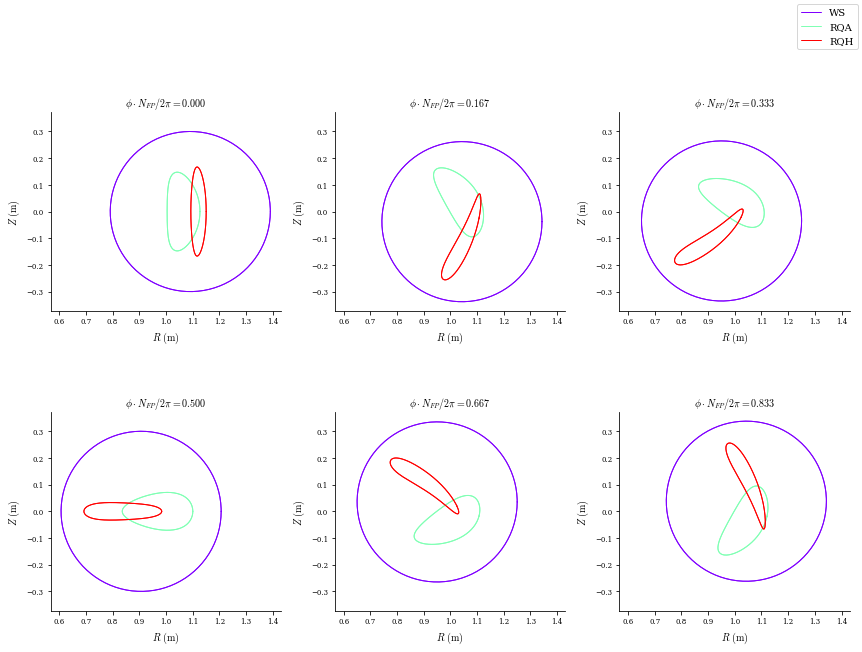

In [7]:
plot_comparison([surf2,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [8]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal to eachother as they vary with surface current to reduce Bn
# first, keep surfs fixed too and just get regcoil-like solutions for each

In [9]:
# Grids
Megrid = 20
Negrid = 20

Msgrid = 20
Nsgrid = 20

egrid = LinearGrid(M=Megrid,N=Negrid,
                   NFP=eq.NFP,
                   sym=False)

sgrid = LinearGrid(M=Msgrid,N=Nsgrid,
                   NFP=eq.NFP,
                   sym=False) 

In [10]:
# Distance target
min_QA = 0.07
max_QA = 0.3

min_QH = 0.07
max_QH = 0.3#0.28

# Distance to veseel penalization
obj_dist_QA = PlasmaVesselDistance(
    eq_QA,
    surf2,
    bounds=(min_QA,max_QA),
    #target = 0.15,
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    weight = 3e0,
    use_signed_distance=True,
    name="distance error  RQA"
)

obj_dist_QH = PlasmaVesselDistance(
    eq_QH,
    surf2,
    #target = 0.15,
    bounds=(min_QH,max_QH),
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    use_signed_distance=True,
    weight = 2e0,#20
    name="distance error  RQH"
)

In [11]:
mean_curv = -0.3
min_mean_curv = 0#-0.5
max_mean_curv = -0.15

obj_mean_curv = MeanCurvature(
    surf2,
    target = 0,
    #bounds = (-1,1),
    weight = 1e-2,
    normalize = True,
    normalize_target = True,
    deriv_mode = "auto",
    grid = sgrid,
    name = "Mean curvature",
)

In [12]:
obj_prin_curv = PrincipalCurvature(surf2,
        target = 0,
        #bounds=(-15,-10),
        weight=5e-2,
        #normalize=True,
        #normalize_target=True,
        #loss_function=None,
        #deriv_mode="auto",
        grid=sgrid,
        name="principal-curvature",
        #jac_chunk_size=None,
    )

In [13]:
obj = ObjectiveFunction((#flux_QA,
                         #flux_QH,
                         obj_dist_QA,
                         obj_dist_QH,
                         #obj_mean_curv,
                         obj_prin_curv,
                         #surf_curr_reg_QA,
                         #surf_curr_reg_QH,
                         #obj_thickness_QA,
                         #obj_thickness_QH,
                         #obj_sigma_QH,
                        )
                       )
constraints = (
    #FixParameters(surf1,{"G":True,}),# fix the secular poloidal current
    FixParameters(surf2,{"G":True,
                         #"R_lmn":True, 
                         #"Z_lmn":True,
                         }
                 ),# fix the secular poloidal current
    # make the 2 surfaces have the same geometry, dont need bc geom is fixed here
    #ShareParameters([surf1,surf2],params={"R_lmn":True, "Z_lmn":True}), 
)

In [14]:
# Choose the optimizer
opt = Optimizer("lsq-exact")

In [15]:
# Run optimization
res,_ = opt.optimize(surf2, 
                                 objective=obj, 
                                 #constraints=constraints,
                                 verbose=3,
                                 maxiter=0,
                                ftol=0,
                                gtol=0,
                                xtol=0,
                                 #options={"initial_trust_radius":np.inf}
                      )

surf2 = res[0]

Building objective: distance error  RQA

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 843 ms

Building objective: distance error  RQH

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 36.4 ms

Building objective: principal-curvature

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 38.6 ms

Timer: Objective build = 1.32 sec

Number of parameters: 525

Number of objectives: 5043

Timer: Initializing the optimization = 1.35 sec


Starting optimization

Using method: lsq-exact

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   

       0              1          9.743e+00                                    5.766e+02   

         Current function value: 9.743e+00

         Total delta_x: 0.000e+00

         Iterations: 0

         Function evaluations: 1

         Jacobian evaluations: 1

Timer: Solution time = 4.92 sec

Timer: Avg time per step = 4.92 sec

                                                                 Start  -->   End

Total (sum of squares):                                      9.743e+00  -->   9.743e+00, 

Maximum Plasma-vessel distance:                              3.257e-01  -->   3.257e-01 (m)

Minimum Plasma-vessel distance:                              8.101e-02  -->   8.101e-02 (m)

Average Plasma-vessel distance:                              2.011e-01  -->   2.011e-01 (m)

Maximum Plasma-vessel distance:                              3.169e+00  -->   3.169e+00 (normalized)

Minimum Plasma-vessel distance:                              7.883e-01  -->   7.883e-01 (normalized)

Average Plasma-vessel distance:                              1.957e+00  -->   1.957e+00 (normalized)

Maximum Plasma-vessel distance:                              3.097e-01  -->   3.097e-01 (m)

Minimum Plasma-vessel distance:                              6.063e-02  -->   6.063e-02 (m)

Average Plasma-vessel distance:                              1.994e-01  -->   1.994e-01 (m)

Maximum Plasma-vessel distance:                              3.235e+00  -->   3.235e+00 (normalized)

Minimum Plasma-vessel distance:                              6.333e-01  -->   6.333e-01 (normalized)

Average Plasma-vessel distance:                              2.083e+00  -->   2.083e+00 (normalized)

Maximum absolute Principal curvature:                        3.690e+00  -->   3.690e+00 (m^-1)

Minimum absolute Principal curvature:                        3.092e+00  -->   3.092e+00 (m^-1)

Average absolute Principal curvature:                        3.377e+00  -->   3.377e+00 (m^-1)

Maximum absolute Principal curvature:                        1.107e+00  -->   1.107e+00 (normalized)

Minimum absolute Principal curvature:                        9.275e-01  -->   9.275e-01 (normalized)

Average absolute Principal curvature:                        1.013e+00  -->   1.013e+00 (normalized)

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

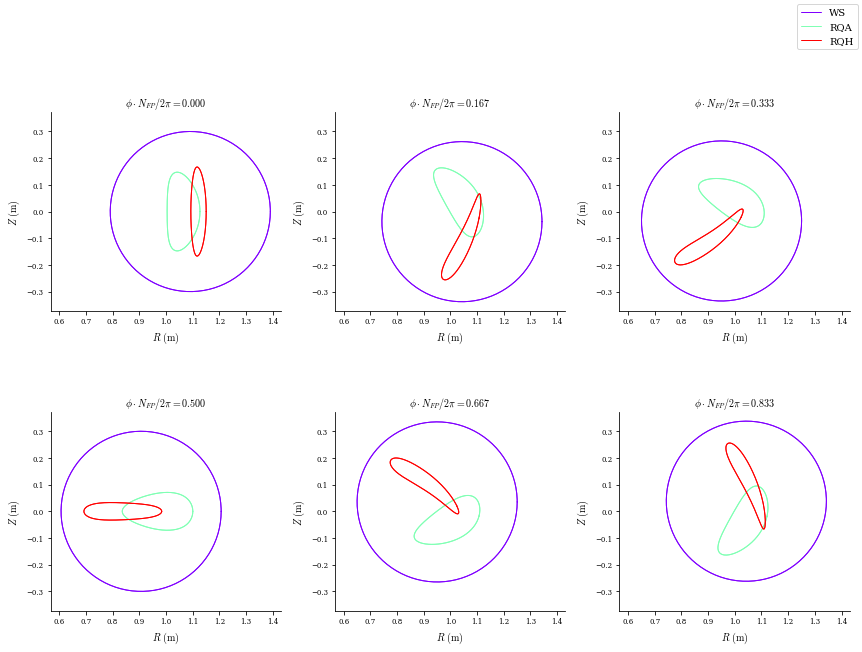

In [16]:
plot_comparison([surf2,
                 eq_QA,
                 eq_QH
                ],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

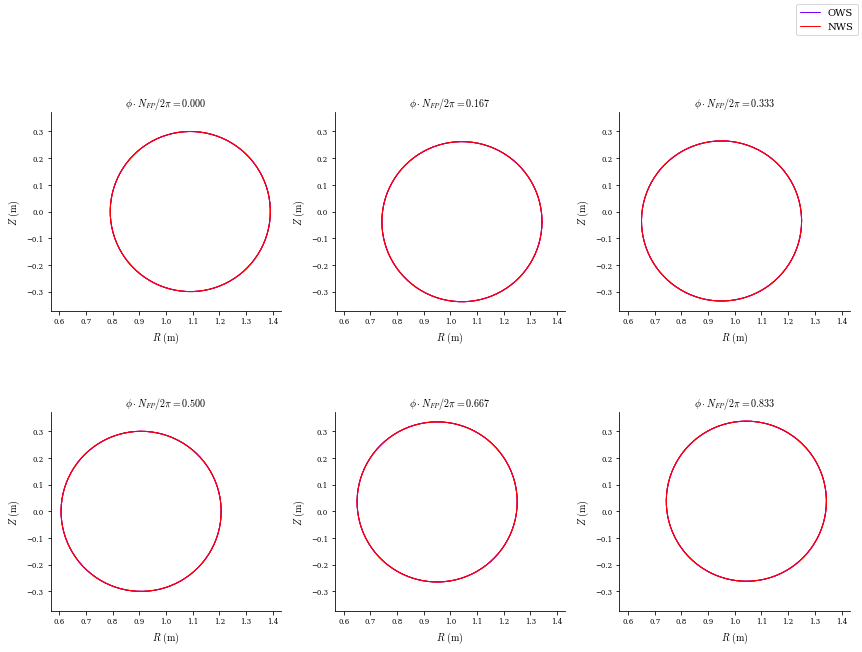

In [17]:
plot_comparison([surf,surf2],
                labels=["OWS","NWS"],
                theta=0,rho=np.array(1.0)
               )

In [18]:
surf2.save("surf_opt.h5")